# Comparison against hand-crafted perception $p(o|w,\lambda)$

Hand craft a perceptual model $p(o|w,\lambda)$ that has a tunable parameter to change $I(O;W)$ according to the information processing constraints - this parameter corresponds to the level of perceptual noise and influences the likelihood of "confusing" one particular $w$ with similar ones.

$w$ is the true size of an animal, animals come in three different size-groups - each group has three members.
*  G1: Small: 2,3,4
*  G2: Medium: 6,7,8
*  G3: Large: 10,11,12

The observation $o$ is a noisy version of $w$, where the precision is goverened by $\lambda$:

$$o \sim \text{round}(\mathcal{N}(w;0,1/\lambda))$$

For medium precision $\lambda$ you'll mostly get within-group confusion, for low precision $\lambda$ you'll get strong across-group confusion. Additionally, you'll get percepts $1,4,8,13$ that lie outside of the groups that "exist in the world" but arise due to unreliable sensors. Technical detail: to avoid a border-bias, any $o$-values outside the interval $[1, 13]$ are rejected and resampled.


In [15]:
using RateDistortionDecisionMaking, Distances, DataFrames, Color, Gadfly, Distributions, Interact, Reactive

#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

## Utility U(a,w)

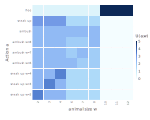

In [16]:
#set up predator-prey example
include("PredatorPreyExample.jl")
#same utility as used in the main paper
w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example()
#alternative utility - mating scenario
#w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example(mating_utility=true)


numa = length(a_strings)
a_vec = [1:numa]

numw = length(w_strings)
w_vec = [1:numw]

#pre-compute utility
U_pre, Umax = setuputilityarrays(a_values,w_values,U)

#visualize utility

plt_utility = visualizeMatrix(U_pre, w_values, a_values, w_strings, a_strings, xlabel="animal size w",
                              ylabel="Action a", legendlabel="U(a,w)")

Possible kinds of **animals**:
*  Small animals (w={2,3,4})
  * Can't hear well - sneaking up on them is very likely succesful
  *  The generic sneak-up pattern works very well
  *  An ambush also works but bears the risk that the animal is not moving towards you
  * For each w2, w3, w4 there is a specific sneak-up pattern that increases chances of success for that particular kind of animal - however, using it on the wrong animal, the success rate will be 20% lower  
*  Medium-sized animals (w={6,7,8})
  *  Can hear well - sneaking up on them has lower chances of success compared to ambush
  *  The generic ambush pattern works well but bears the risk that the animal is not moving towards you
  *  A sneak up might also work but chances are quite low
  *  There are specific ambush patterns for w6, w7, w8 but using them has no advantage over the generic ambush, however using them on the wrong animal, the sucess rate will be 20% lower 
*  Large animals (w={10,11,12})
  *  Can potentially kill you, your chances of survival are low if you sneak up or ambush them (no matter with which kind of pattern)
  *  If you flee, your chances of survival are quite good
  
  
Possible kinds of **actions**:
*  Generic *Ambush*: wait for the animal to get close and then strike
  *  advantage: causes no noise
  *  disadvantage: animal might not come towards you
*  Generic *Sneak up*: slowly move closer to the animal and then strike
  *  advantage: works also if animal is not moving towards you
  *  disadvantage: animal might hear or you and flee
*  Generic *Flee*: run away from animal
  *  advantage: if animal could kill you, your chances of survival are significantly increased
  *  disadvantage: if animal was potential prey you missed out on food
*  Specific *Sneak up* for w={2,3,4}: specific sneak up pattern that increases success when applied to exactly the right kind of animal, but decreases success when applied to another animal within the small animal group. When applied to an animal from the medium-sized animal group, the success-rate is equal to the generic sneak up pattern.
*  Specific *Ambush* for w={6,7,8}: does not increase success compared to generic ambush pattern, but decreases success when applied to another animal within the medium-sized group. When applied to an animal from the small group, the success-rate is equal to the generic ambush pattern. As there is no advantage of the specific pattern over the genric pattern (but it might be disadvantegous when applied to the wrong animal), any bounded-rational decision-maker should assign no probability mass to these specific ambush patterns since using them would not increase the expected utility but would increase the informational cost.


  
  
Compared to the generic sneak-up and ambush patterns, the specific pattern require more computational resources, that is they require a larger capacity on the action-channel, or in other words: they require good motor skills and a good motor hardware (which is more costly than a cheap motor system).

If you have bad motoric hardware, you'll never be able to use the specific hunting patterns, therefore it doesn't make sense to waste resources on an expensive perceptual system that allows you to precisely distinguish individual animals. Rather a system that allows you to tell the different groups from each other suffices. Dually, if your perceptual system does not allow you to distinguish between the individual animals, it would be lavish to have an expensive motor system that allows you to accurately execute very specific hunting patterns.


**TODO: describe mating utility**

## Hand-crafted perceptual model $p(o|w,\lambda)$

Slider{Float64}([Input{Float64}] 2.5,"Perceptual precision λ",2.5,0.1:0.1:5.0)

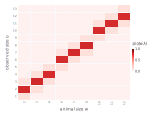

In [17]:
#set up hand-crafted likelihood model and p(o|w)
o_values = [1:13]
o_vec = [1:length(o_values)]
o_strings = map((x)->string(x), o_values)


#slider for selecting λ
λ_vals = 0.1:0.1:5
slider_l = slider(λ_vals,label="Perceptual precision λ")


#use lift to connect the actual plotting-code to the dropdown box
plt_pogw_sl = lift(λ_vis->begin
                            p_ogw_hc = pogw_handcrafted(o_values, w_values, λ_vis)
                            visualizeBAconditional(p_ogw_hc, o_vec, w_vec, o_strings, w_strings,
                                                   wlabel="animal size w", alabel="observed size o", legendlabel="p(o|w,λ)")
                            end, slider_l)

display(slider_l)
display(plt_pogw_sl)

#TODO: perhaps do a σ-sweep and plot how I(O;W) evolves? (low priority)

Drag the slider above to change the perceptual precision and see how observations get more and more "blurry" with decreasing precision. Note that low perceptual precision incurs a low mutual information $I(O;W)$ whereas high precision also incurs a large mutual information between the actual size and the observed size.

## Set parameters to compare the two cases here:
When changing the parameters make sure to re-run the corresponding cells below - in case of doubt simply re-run all cells below.

In [58]:
#precision of the hand-crafted perceptual model
λ = 0.4 #1.65
#the "price" for I(O;W) in the handcrafted case will be β1 (as given below)
#to make the two cases comparable. If you want I(O;W) to be the same in both
#cases, set β1 and run the sequential case and then tune λ until the mutual
#information terms are equal.
#
#Note that β2 will also be used for the bounded rational decision-maker that
#uses the hand-crafted perception. This should allow for easy comparison of
#the action-channels in both cases (hand-crafted vs. sequential case)

#inverse temperatures for sequential case
#β1: perceptual channel -> price for I(O;W)
#β2: action channel -> price for I(A;O)
#β3=0 sequential case (otherwise the general three-variable case is specified)
β1 = 1
β2 = 10
β3 = 0;

### Cases that work nicely:

*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 10$ (same $I(O;W)$ for both models - almost unbounded actor)
*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 1$ (same EU - bounded actor, optimal perception changes, given the limits on the action channel)
*  $\lambda=0.4$, $\beta_1 = 1$, $\beta_2 = 10$ (same $I(O;W)$ for both models - bounded actor, optimal action changes, given the limits on the perceptual channel)



*  $\lambda=10$, $\beta_1 = 10$, $\beta_2 = 5$, mating-utility (optimal perception changes under a different utility function - compare against case above with identical parameters but different utility function)

### Things to try:

Change the temp on the action-channel (with very large resources on the observation channel) and see how the perception is affected by the action.

Change the temp on the perception-channel (with very large resources on the action channel) and see how the action is affected by perception.

Change utility function (mating-utility) and see how the percept is affected by the new utility.

## Bounded rational decision maker based on hand-crafted perception

In [59]:
#compute hand-crafted perception, then feed it into bounded rational decision-maker
#with inv. temperature β2 and compute optimal p(a|o) using hand-crafted p(o|w)
p_ogw_hc = pogw_handcrafted(o_values, w_values, λ)


numo = length(o_vec)
numa = length(a_vec)

#comptue expected utility under posterior over w given o
#
#posterior p(w|o)
p_wgo = zeros(numw, numo)
for k in 1:numo
    p_wgo[:,k] = p_ogw_hc[k,:]' .* p_w
    p_wgo[:,k] += eps()  #add small epsilon to prevent numerical problems for λ>>
    p_wgo[:,k] /= sum(p_wgo[:,k])
end

#U(a,o)=∑_w p(w|o)U(a,w)
U_ao = zeros(numa, numo)
for k in 1:numo
    U_ao[:,k] = U_pre * p_wgo[:,k]
end


#p(o)=∑_w p(w)p(o|w)
p_o_hc = p_ogw_hc * p_w
#make sure that p(o) has non-zero entries (otherwise numerical problems arise in I(O;W))
p_o_hc += eps()
p_o_hc /= sum(p_o_hc)


#solve the decision-making part with one-step Blahut-Arimoto
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 5000 #maximum number of BA iterations

#initialize p(a) uniformly
num_acts = length(a_vec)
pa_init = rand(num_acts)
pa_init /= sum(pa_init)

#BA iterations
p_ago_hc, p_a_hc, perf_df_hc = BAiterations(pa_init, β2, U_ao, p_o_hc, ε, maxiter,
                                            compute_performance=true, performance_as_dataframe=true)

; #suppress output

In [60]:
#visualize solution p(o|w), p(a|o), p(a|w)

#p(o|w)
plt_pogw_hc = visualizeBAconditional(p_ogw_hc, o_vec, w_vec, o_strings, w_strings,
                                     wlabel="animal size w", alabel="observed size o", legendlabel="p(o|w,λ)")

#p(a|o)
plt_pa_hc, plt_pago_hc = visualizeBAsolution(p_a_hc, p_ago_hc, a_vec, o_vec, a_strings, o_strings,
                                             wlabel="observed size o", alabel="action a",
                                             legendlabel_marginal="p(a)", legendlabel_conditional="p(a|o,λ)",
                                             suppress_vis=true)

#compute p(a|w)
#p(a|w) = ∑_o p(o|w)p(a|o)
p_agw_hc =  p_ago_hc * p_ogw_hc
plt_pagw_hc = visualizeBAconditional(p_agw_hc, a_vec, w_vec, a_strings, w_strings,
                                     wlabel="animal size w", alabel="action a", legendlabel="p(a|w,λ)")


#visualize p(o|w)
display(plt_pogw_hc)
#visualize p(a|o)
display(plt_pago_hc)
#visualize p(a|w)
display(plt_pagw_hc)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(o|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 observed size o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 observed size o 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|o,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

In [61]:
#compute p(a|o,w) = p(a|o) ∀w
p_agow_hc = zeros(numa, numo, numw)
for j in 1:numw
    p_agow_hc[:,:,j] = p_ago_hc
end

#compute performance measures of solution
res_hc = analyze_three_var_BAsolution(p_w, p_o_hc, p_a_hc, p_ogw_hc, p_ago_hc, p_agow_hc, p_agw_hc, U_pre, β1, β2, β3)
perf_df_hc = performancemeasures2DataFrame(res_hc...)
    
#visualize
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(perf_df_hc, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 -1.50 
 -1.45 
 -1.40 
 -1.35 
 -1.30 
 -1.25 
 -1.20 
 -1.15 
 -1.10 
 -1.05 
 -1.00 
 -0.95 
 -0.90 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 1.65 
 1.70 
 1.75 
 1.80 
 1.85 
 1.90 
 1.95 
 2.00 
 2.05 
 2.10 
 2.15 
 2.20 
 2.25 
 2.30 
 2.35 
 2.40 
 2.45 
 2.50 
 2.55 
 2.60 
 2.65 
 2.70 
 2.75 
 2.80 
 2.85 
 2.90 
 2.95 
 3.00 
 -2 
 0 
 2 
 4 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

## Two-step sequential bounded rational decision maker (perception + action)

Particularly for high $\beta$ structured (sparse) initializations of $p(o|w)$ seem to work better.

In [62]:
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 5000 #maximum number of BA iterations



#This function performs Blahut-Arimoto iterations for the three-variable general case
po, pa, pogw, pago, pagow, pagw, performance_df = threevarBAiterations(numo, β1, β2, β3, U_pre, p_w, ε, maxiter,
                                                  compute_performance=true, performance_as_dataframe=true,
                                                  init_pogw_sparse = true, init_pogw_uniformly = false,
                                                  init_pagow_uniformly = true);

In [63]:
#call the routine that creates plots for all the probability distributions
plt_po, plt_pa, plt_pogw, plt_pago, plt_pagw, dpdown, plt_pagow_vis = visualize_three_var_BAsolution(po, pa,
                                                                      pogw, pago, pagow, pagw,
                                                                      o_vec, a_vec, w_vec,
                                                                      o_strings, a_strings, w_strings, 
                                                                      olabel_string="o", alabel_string="a", wlabel_string="w")

#visualize p(o|w)
display(plt_pogw)
#visualize p(a|o)
display(plt_pago)
#visualize p(a|w)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(o|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 Observation o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Observation o 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

In [64]:
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(performance_df, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 -1.00 
 -0.95 
 -0.90 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 1.65 
 1.70 
 1.75 
 1.80 
 1.85 
 1.90 
 1.95 
 2.00 
 -1 
 0 
 1 
 2 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

## Compare hand-crafted $p(o|w,\lambda)$ vs. bounded-optimal $p^*(o|w)$

In [65]:
#compare both solutions

#compare performance measures, EU, J, I(A;W)

util_all = [perf_df_hc[end,:E_U], performance_df[end,:E_U],
            perf_df_hc[end,:Objective_value], performance_df[end,:Objective_value]]

color_label = ["E[U]_hc", "E[U]", "J_hc", "J"]

colors = BAdiscretecolorscale(4).f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[end],colors[end])

p_perf_comp = plot(x=color_label, y=util_all, color=color_label, Geom.bar(),
                   Guide.ylabel("[utils]"), Guide.xlabel(""), Guide.colorkey(""),
                   Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                   colscale, Scale.y_continuous(minvalue=0, maxvalue=maximum(U_pre)),
                   BAtheme(key_position = :none))


MI_comp = [perf_df_hc[end,:I_ow], performance_df[end,:I_ow],
           perf_df_hc[end,:I_ao], performance_df[end,:I_ao]]
color_label = ["I(O;W)_hc", "I(O;W)", "I(A;O)_hc", "I(A;O)"]

colors = Scale.color_discrete_hue().f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[2],colors[2])

p_perf_comp_MI = plot(x=color_label, y=MI_comp, color=color_label, Geom.bar(),
                      Guide.ylabel("[bits]"), Guide.xlabel(""), Guide.colorkey(""),
                      Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                      colscale, Scale.y_continuous(minvalue=0), BAtheme(key_position = :none))

display(hstack(p_perf_comp,p_perf_comp_MI))

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(O;W)_hc 
 I(O;W) 
 I(A;O)_hc 
 I(A;O) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 -1.50 
 -1.45 
 -1.40 
 -1.35 
 -1.30 
 -1.25 
 -1.20 
 -1.15 
 -1.10 
 -1.05 
 -1.00 
 -0.95 
 -0.90 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 1.65 
 1.70 
 1.75 
 1.80 
 1.85 
 1.90 
 1.95 
 2.00 
 2.05 
 2.10 
 2.15 
 2.20 
 2.25 
 2.30 
 2.35 
 2.40 
 2.45 
 2.50 
 2.55 
 2.60 
 2.65 
 2.70 
 2.75 
 2.80 
 2.85 
 2.90 
 2.95 
 3.00 
 -2 
 0 
 2 
 4 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 
 
 [bits] 
 
 
 λ=0.4 vs. β1=1, β2=10, β3=0 
 
 
 
 
 E[U]_hc 
 E[U] 
 J_hc 
 J 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 λ=0.4 vs. β1=1, β2=10, β3=0

In [66]:
#compare final behavior p(a|w) of both cases
display(plt_pagw_hc)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

In [67]:
#compare perceptual model p(o|w) of both cases
display(plt_pogw_hc)
display(plt_pogw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(o|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 observed size o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(o|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 Observation o

In [69]:
#generate plots for comparison

#display(plt_utility)
#draw(SVG("Figures/SequentialComparison_Utility.svg", 10cm, 8cm), plt_utility) #uncomment to store figure


#plot_final = vstack(hstack(plt_pogw_hc, plt_pagw_hc),hstack(plt_pogw, plt_pagw))
#plot_bars = (vstack(p_perf_comp,p_perf_comp_MI))
#display(plot_final)
#display(plot_bars)
#draw(SVG("Figures/SequentialComparison_3.svg", 18cm, 12cm), plot_final) #uncomment to store figure#
#draw(SVG("Figures/SequentialComparisonBars_3.svg", 8cm, 12cm), plot_bars) #uncomment to store figure


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a 
 
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(o|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 Observation o 
 
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a 
 
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(o|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 observed size o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(O;W)_hc 
 I(O;W) 
 I(A;O)_hc 
 I(A;O) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 -1.50 
 -1.45 
 -1.40 
 -1.35 
 -1.30 
 -1.25 
 -1.20 
 -1.15 
 -1.10 
 -1.05 
 -1.00 
 -0.95 
 -0.90 
 -0.85 
 -0.80 
 -0.75 
 -0.70 
 -0.65 
 -0.60 
 -0.55 
 -0.50 
 -0.45 
 -0.40 
 -0.35 
 -0.30 
 -0.25 
 -0.20 
 -0.15 
 -0.10 
 -0.05 
 0.00 
 0.05 
 0.10 
 0.15 
 0.20 
 0.25 
 0.30 
 0.35 
 0.40 
 0.45 
 0.50 
 0.55 
 0.60 
 0.65 
 0.70 
 0.75 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00 
 1.05 
 1.10 
 1.15 
 1.20 
 1.25 
 1.30 
 1.35 
 1.40 
 1.45 
 1.50 
 1.55 
 1.60 
 1.65 
 1.70 
 1.75 
 1.80 
 1.85 
 1.90 
 1.95 
 2.00 
 2.05 
 2.10 
 2.15 
 2.20 
 2.25 
 2.30 
 2.35 
 2.40 
 2.45 
 2.50 
 2.55 
 2.60 
 2.65 
 2.70 
 2.75 
 2.80 
 2.85 
 2.90 
 2.95 
 3.00 
 -2 
 0 
 2 
 4 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 
 
 [bits] 
 
 
 λ=0.4 vs. β1=1, β2=10, β3=0 
 
 
 
 
 E[U]_hc 
 E[U] 
 J_hc 
 J 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 λ=0.4 vs. β1=1, β2=10, β3=0